In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.loss import *
from tomopt.volume import *
from tomopt.core import *
from tomopt.optimisation import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [3]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [4]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [5]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [7]:
volume = Volume(get_layers())

# VolumeWrapper

In [8]:
from functools import partial

In [9]:
volume = Volume(get_layers())

In [10]:
wrapper = VolumeWrapper(volume=volume, res_opt=partial(torch.optim.SGD, lr=2e1), eff_opt=partial(torch.optim.SGD, lr=2e-5), loss_func=DetectorLoss(0.15))

In [11]:
trn_passives = PassiveYielder([arb_rad_length])

In [12]:
for p in trn_passives: print(p)

<function arb_rad_length at 0x7fca49f22280>


wrapper.fit(10, n_mu_per_volume=1000, passive_bs=1, mu_bs=1000, trn_passives=trn_passives, val_passives=None, cbs=[NoMoreNaNs()])

In [21]:
volume.state_dict()

OrderedDict([('layers.0.resolution',
              tensor([[1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
                      [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
                      [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
                      [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
                      [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
                      [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
                      [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
                      [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
                      [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
                      [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]])),
             ('layer

In [13]:
%time p = wrapper.predict(n_mu_per_volume=1, mu_bs=1, passives=trn_passives)

CPU times: user 26 ms, sys: 1.78 ms, total: 27.8 ms
Wall time: 27.5 ms


In [14]:
%time p = wrapper.predict(n_mu_per_volume=10, mu_bs=10, passives=trn_passives)

CPU times: user 50.1 ms, sys: 5.12 ms, total: 55.2 ms
Wall time: 53.9 ms


In [15]:
%time p = wrapper.predict(n_mu_per_volume=100, mu_bs=100, passives=trn_passives)

CPU times: user 386 ms, sys: 71.3 ms, total: 457 ms
Wall time: 410 ms


In [16]:
%time p = wrapper.predict(n_mu_per_volume=1000, mu_bs=1000, passives=trn_passives)

CPU times: user 16.7 s, sys: 2.32 s, total: 19.1 s
Wall time: 13.3 s


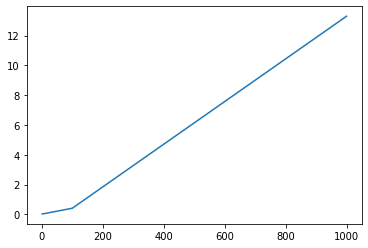

In [18]:
x = [1,10,100,1000]
y = [27.5e-3, 53.9e-3, 410e-3, 13.3]
plt.plot(x,y)

In [17]:
p[0].shape

(6, 10, 10)